In [ ]:
print("Isabela Ruiz - Natalia Cabrera")

Isabela Ruiz - Natalia Cabrera


## 0. Cargar y preprocesar imágenes

### Descargar y obtener la ruta al dataset


In [ ]:
!pip install kagglehub

In [1]:
import kagglehub

path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Ruta del dataset:", path)

Ruta del dataset: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


### Verifica el contenido del path

In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset"

for root, dirs, files in os.walk(dataset_path):
    print("Directorio:", root)
    for d in dirs:
        print(d)
    for f in files:
        print(f)
    break


Directorio: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset
Train
Test


### Cargar imágenes en Colab

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Ruta al dataset
base_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset"
train_path = os.path.join(base_path, "Train")

# Aumentación y normalización
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validación
)

# Generador para entrenamiento
train_gen = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Generador para validación
val_gen = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 18901 images belonging to 18 classes.
Found 4718 images belonging to 18 classes.


### Visualizar Imagenes

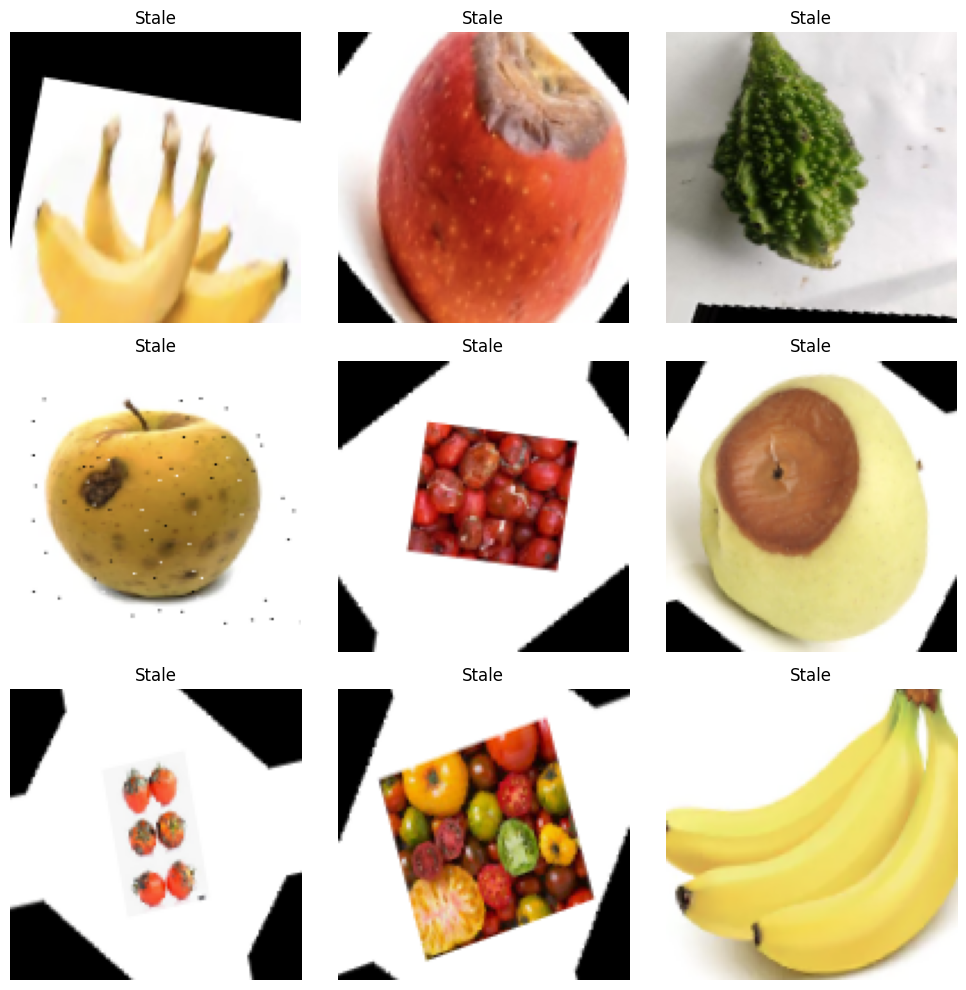

In [4]:
import matplotlib.pyplot as plt

# Obtener un batch del generador
images, labels = next(train_gen)

# Mostrar las primeras 9 imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title("Fresh" if labels[i] == 0 else "Stale")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 1. Transformaciones Geométricas y Data Augmentation

### Cargar imagen prueba

In [5]:
folder = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train/freshapples"

for f in os.listdir(folder):
    print(f)


translation_Screen Shot 2018-06-08 at 5.33.47 PM.png
a_f682.png
saltandpepper_Screen Shot 2018-06-08 at 5.25.43 PM.png
rotated_by_60_Screen Shot 2018-06-08 at 5.07.52 PM.png
vertical_flip_Screen Shot 2018-06-08 at 5.17.04 PM.png
rotated_by_45_Screen Shot 2018-06-08 at 5.29.18 PM.png
rotated_by_60_Screen Shot 2018-06-08 at 5.10.03 PM.png
a_f289.png
Screen Shot 2018-06-08 at 5.21.31 PM.png
rotated_by_45_Screen Shot 2018-06-08 at 5.14.48 PM.png
a_f111.png
rotated_by_45_Screen Shot 2018-06-08 at 5.07.05 PM.png
a_f545.png
vertical_flip_Screen Shot 2018-06-08 at 5.15.45 PM.png
Screen Shot 2018-06-08 at 5.21.56 PM.png
Screen Shot 2018-06-08 at 5.00.43 PM.png
rotated_by_60_Screen Shot 2018-06-08 at 5.27.54 PM.png
vertical_flip_Screen Shot 2018-06-08 at 5.26.47 PM.png
a_f516.png
rotated_by_45_Screen Shot 2018-06-08 at 5.25.49 PM.png
rotated_by_75_Screen Shot 2018-06-08 at 5.22.15 PM.png
rotated_by_15_Screen Shot 2018-06-08 at 5.11.24 PM.png
translation_Screen Shot 2018-06-08 at 5.28.15 PM.png
t

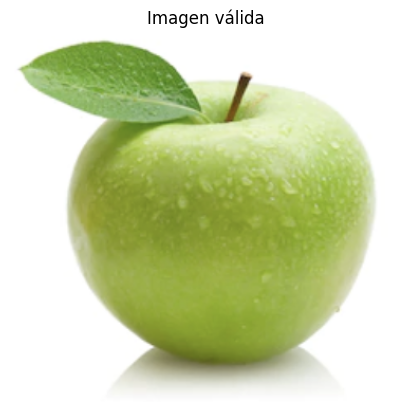

In [6]:
import cv2

img_path = os.path.join(folder, "Screen Shot 2018-06-08 at 5.03.47 PM.png")
img = cv2.imread(img_path)

if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Imagen válida")
    plt.axis('off')
    plt.show()
else:
    print("La imagen no se pudo cargar.")


### Rotaciones

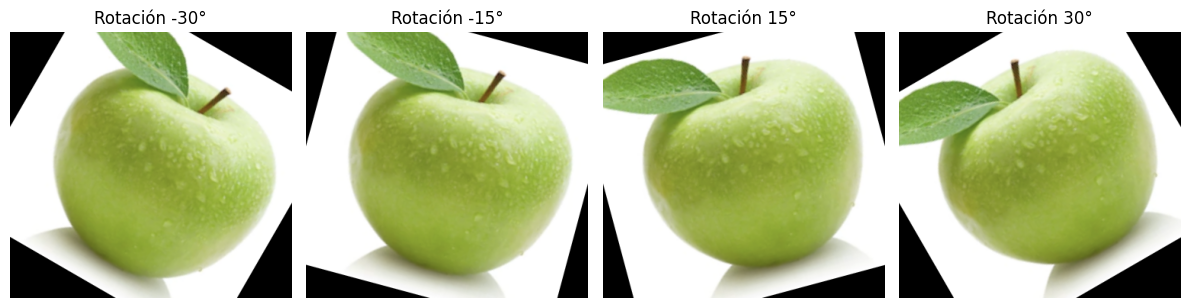

In [7]:
def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    return rotated

# Aplicar rotaciones
angles = [-30, -15, 15, 30]
rotated_imgs = [rotate_image(img, a) for a in angles]

# Mostrar
plt.figure(figsize=(12, 3))
for i, r in enumerate(rotated_imgs):
    plt.subplot(1, 4, i+1)
    plt.imshow(r)
    plt.title(f"Rotación {angles[i]}°")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Escalado (zoom in y zoom out)

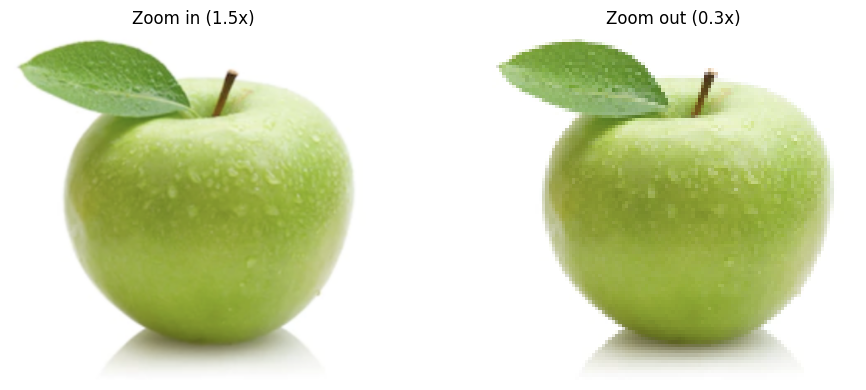

In [8]:
def scale_image(img, fx=1.2, fy=1.2):
    return cv2.resize(img, None, fx=fx, fy=fy)

zoom_in = scale_image(img, 1.5, 1.5)
zoom_out = scale_image(img, 0.3, 0.3)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(zoom_in)
plt.title("Zoom in (1.5x)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(zoom_out)
plt.title("Zoom out (0.3x)")
plt.axis('off')
plt.tight_layout()
plt.show()


Traslaciones (desplazar imagen)

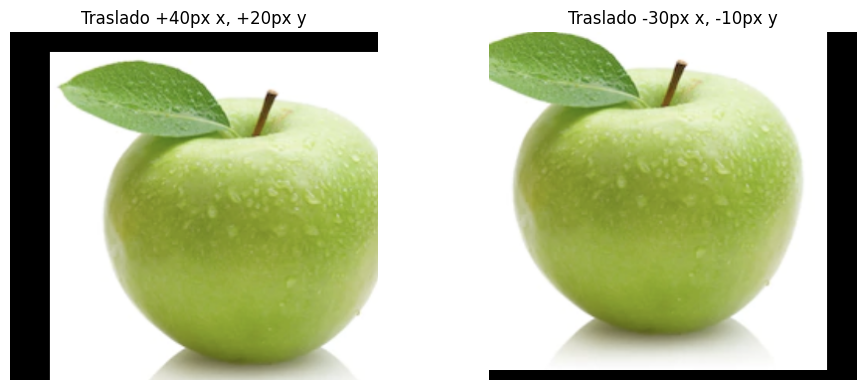

In [9]:
import numpy as np

def translate_image(img, tx=30, ty=30):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

translated1 = translate_image(img, 40, 20)
translated2 = translate_image(img, -30, -10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(translated1)
plt.title("Traslado +40px x, +20px y")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(translated2)
plt.title("Traslado -30px x, -10px y")
plt.axis('off')
plt.tight_layout()
plt.show()


### Reflexión / Volteo (Flip)

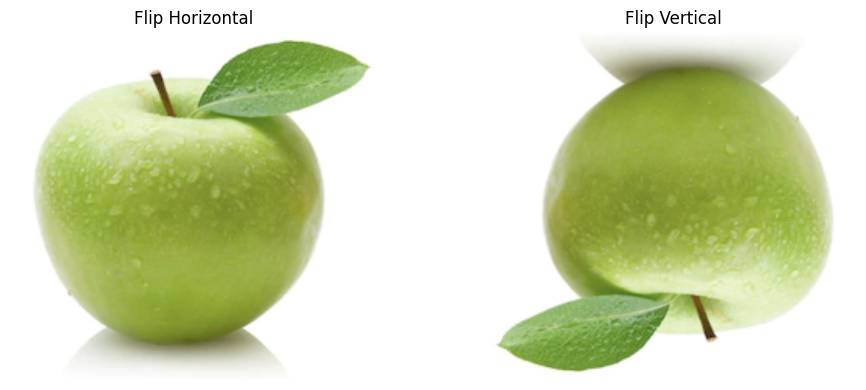

In [10]:
flip_h = cv2.flip(img, 1)  # horizontal
flip_v = cv2.flip(img, 0)  # vertical

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(flip_h)
plt.title("Flip Horizontal")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flip_v)
plt.title("Flip Vertical")
plt.axis('off')
plt.tight_layout()
plt.show()


### Corrección geométrica / alineación

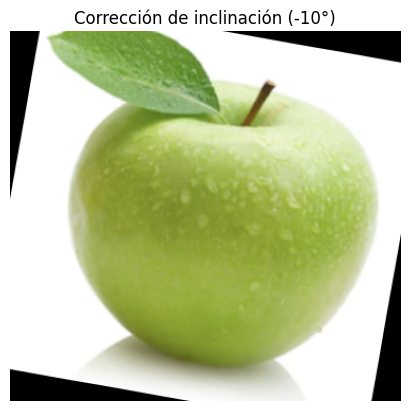

In [11]:
corrected = rotate_image(img, -10)  # simulando corrección

plt.imshow(corrected)
plt.title("Corrección de inclinación (-10°)")
plt.axis('off')
plt.show()


### Aplicar a todas la imagenes

In [12]:
import os
import cv2
from tqdm import tqdm
import numpy as np  # Asegúrate de importar numpy

# Ruta base del dataset original
base_input_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset"
base_output_path = "/content/dataset_augmented"

# Aumentos personalizados
def generate_augmentations(img):
    result = []
    result.append(rotate_image(img, 15))
    result.append(rotate_image(img, -15))
    result.append(scale_image(img, 1.2, 1.2))
    result.append(translate_image(img, 25, 15))
    result.append(cv2.flip(img, 1))  # flip horizontal
    result.append(cv2.flip(img, 0))  # flip vertical
    return result

# Funciones geométricas
def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def scale_image(img, fx=1.2, fy=1.2):
    return cv2.resize(img, None, fx=fx, fy=fy)

def translate_image(img, tx=30, ty=30):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# Función principal
def augment_dataset(split):  # split = "Train" o "Test"
    input_dir = os.path.join(base_input_path, split)
    output_dir = os.path.join(base_output_path, f"{split}_aug")

    for class_folder in os.listdir(input_dir):
        # Solo procesar 'fresh apples' y 'rotten apples'
        if class_folder not in ['fresh apples', 'rotten apples']:
            continue

        class_input_path = os.path.join(input_dir, class_folder)
        class_output_path = os.path.join(output_dir, class_folder)

        os.makedirs(class_output_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_input_path), desc=f"Procesando {class_folder}"):
            input_img_path = os.path.join(class_input_path, img_name)

            img = cv2.imread(input_img_path)
            if img is None:
                continue

            # Guardar imagen original también
            base_name = os.path.splitext(img_name)[0]
            cv2.imwrite(os.path.join(class_output_path, f"{base_name}_orig.jpg"), img)

            augmentations = generate_augmentations(img)
            for i, aug in enumerate(augmentations):
                out_name = f"{base_name}_aug{i}.jpg"
                out_path = os.path.join(class_output_path, out_name)
                cv2.imwrite(out_path, aug)

# Ejecutar para Train y Test
augment_dataset("Train")
augment_dataset("Test")


## 2. Filtrado y Convolución

### Preparar imagen en escala de grises

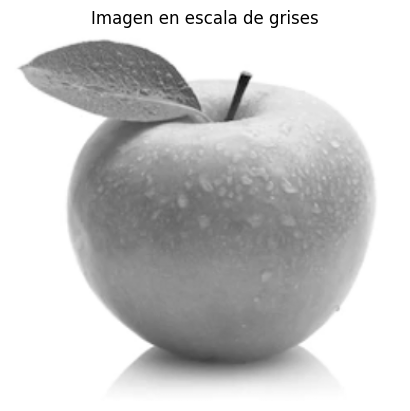

In [13]:
import cv2
import matplotlib.pyplot as plt

# Imagen de ejemplo
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap='gray')
plt.title("Imagen en escala de grises")
plt.axis('off')
plt.show()


### Suavizado (para reducir ruido)

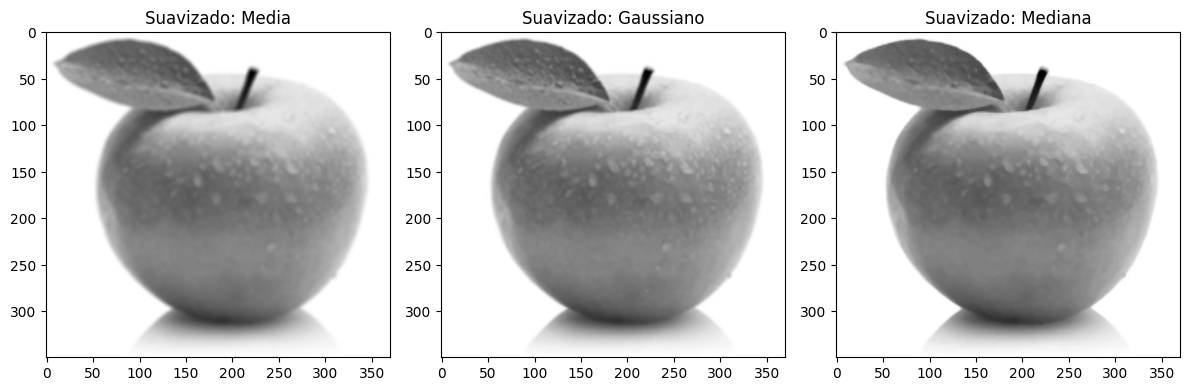

In [14]:
blur_avg = cv2.blur(gray, (5, 5))             # Filtro de media
blur_gauss = cv2.GaussianBlur(gray, (5, 5), 0) # Filtro Gaussiano
blur_median = cv2.medianBlur(gray, 5)         # Filtro de mediana

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(blur_avg, cmap='gray')
plt.title("Suavizado: Media")

plt.subplot(1, 3, 2)
plt.imshow(blur_gauss, cmap='gray')
plt.title("Suavizado: Gaussiano")

plt.subplot(1, 3, 3)
plt.imshow(blur_median, cmap='gray')
plt.title("Suavizado: Mediana")
plt.tight_layout()
plt.show()


### Filtro de Bordes - Sobel

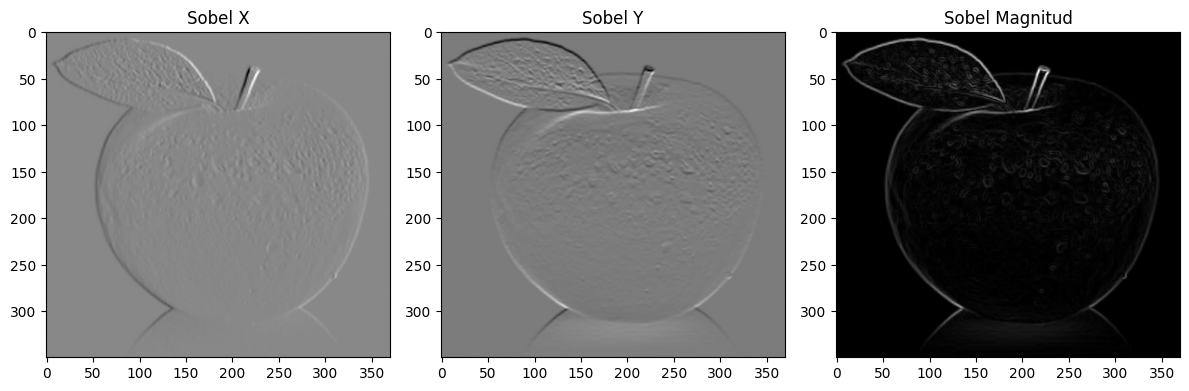

In [15]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Derivada en X
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Derivada en Y
sobel_mag = cv2.magnitude(sobelx, sobely)           # Magnitud total

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sobelx, cmap='gray')
plt.title("Sobel X")

plt.subplot(1, 3, 2)
plt.imshow(sobely, cmap='gray')
plt.title("Sobel Y")

plt.subplot(1, 3, 3)
plt.imshow(sobel_mag, cmap='gray')
plt.title("Sobel Magnitud")
plt.tight_layout()
plt.show()


### Filtro de Bordes - Prewitt (implementado manualmente)

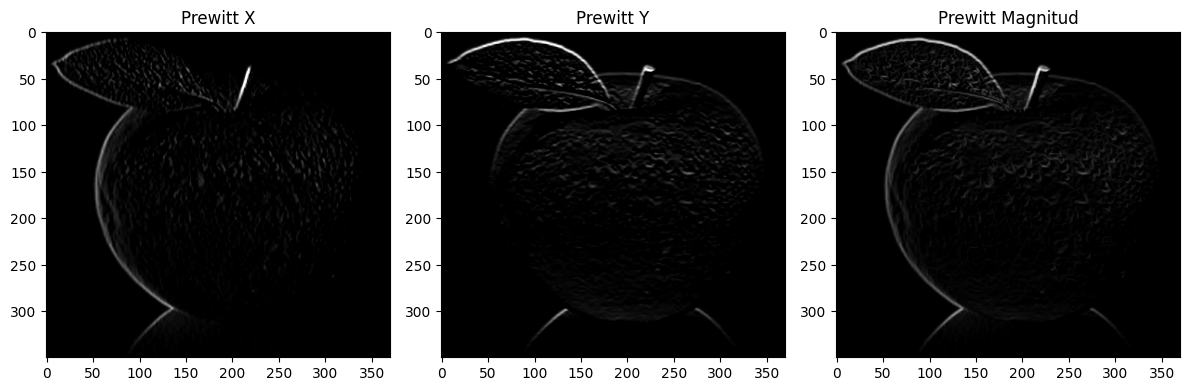

In [16]:
import numpy as np

# Kernels de Prewitt
kernelx = np.array([[1, 0, -1],
                    [1, 0, -1],
                    [1, 0, -1]], dtype=np.float32)

kernely = np.array([[1,  1,  1],
                    [0,  0,  0],
                    [-1, -1, -1]], dtype=np.float32)

prewitt_x = cv2.filter2D(gray, -1, kernelx)
prewitt_y = cv2.filter2D(gray, -1, kernely)
prewitt_mag = cv2.magnitude(np.float32(prewitt_x), np.float32(prewitt_y))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(prewitt_x, cmap='gray')
plt.title("Prewitt X")

plt.subplot(1, 3, 2)
plt.imshow(prewitt_y, cmap='gray')
plt.title("Prewitt Y")

plt.subplot(1, 3, 3)
plt.imshow(prewitt_mag, cmap='gray')
plt.title("Prewitt Magnitud")
plt.tight_layout()
plt.show()


### Comparativa final

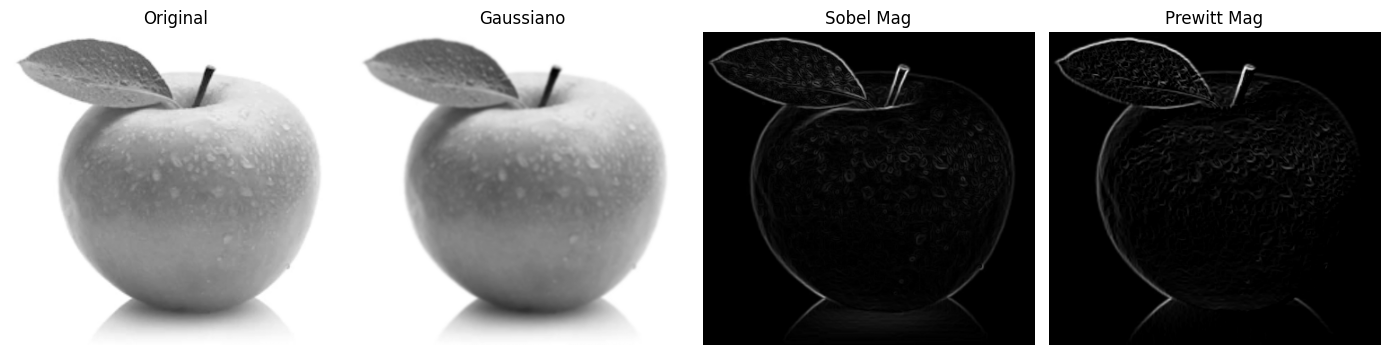

In [17]:
titles = ['Original', 'Gaussiano', 'Sobel Mag', 'Prewitt Mag']
images = [gray, blur_gauss, sobel_mag, prewitt_mag]

plt.figure(figsize=(14, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## 3. Detección de bordes y umbralización

### Convertir imagen a escala de grises y aplicar suavizado

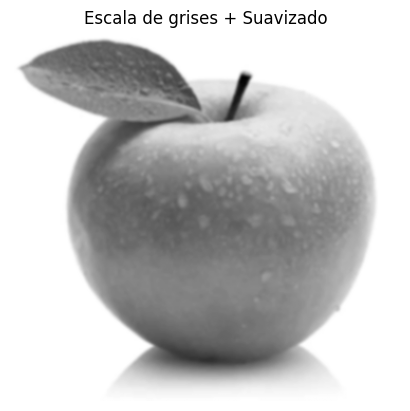

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(blur, cmap='gray')
plt.title("Escala de grises + Suavizado")
plt.axis('off')
plt.show()


### Canny

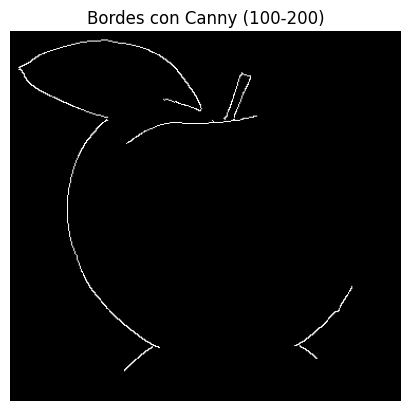

In [19]:
canny = cv2.Canny(blur, threshold1=100, threshold2=200)

plt.imshow(canny, cmap='gray')
plt.title("Bordes con Canny (100-200)")
plt.axis('off')
plt.show()


### Laplaciano

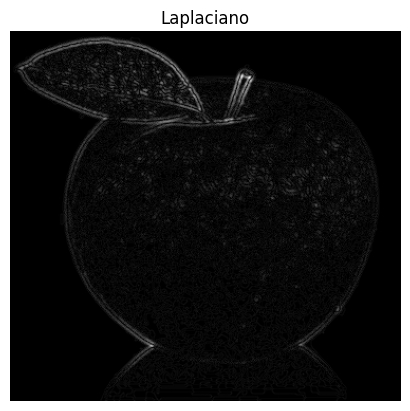

In [20]:
laplacian = cv2.Laplacian(blur, cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

plt.imshow(laplacian, cmap='gray')
plt.title("Laplaciano")
plt.axis('off')
plt.show()


### Umbralización global (valor fijo)


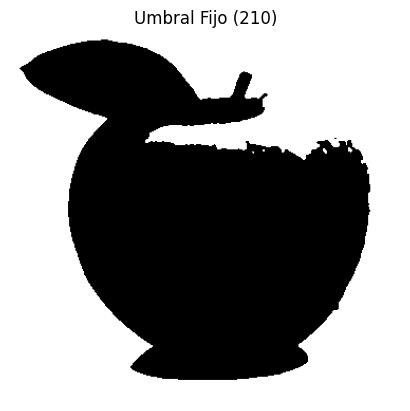

In [21]:
_, thresh_global = cv2.threshold(blur, 210, 255, cv2.THRESH_BINARY)

plt.imshow(thresh_global, cmap='gray')
plt.title("Umbral Fijo (210)")
plt.axis('off')
plt.show()


### Umbralización adaptativa

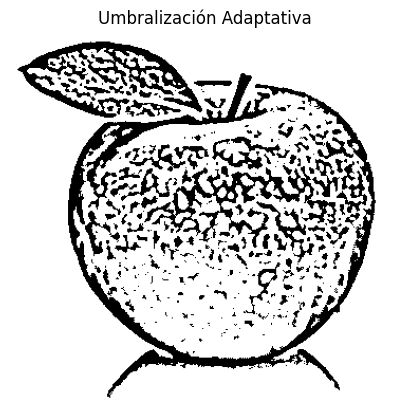

In [22]:
thresh_adapt = cv2.adaptiveThreshold(
    blur, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,  # O usa cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    cv2.THRESH_BINARY,
    blockSize=11,
    C=2
)

plt.imshow(thresh_adapt, cmap='gray')
plt.title("Umbralización Adaptativa")
plt.axis('off')
plt.show()


### Umbralización de Otsu


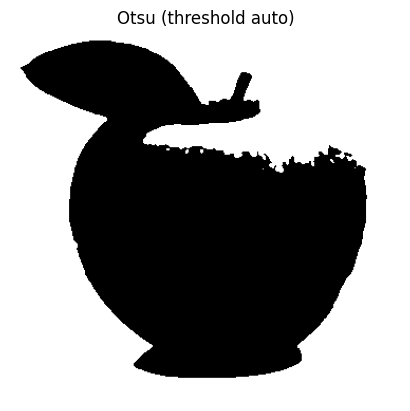

In [23]:
_, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(otsu, cmap='gray')
plt.title(f"Otsu (threshold auto)")
plt.axis('off')
plt.show()


### Comparacion

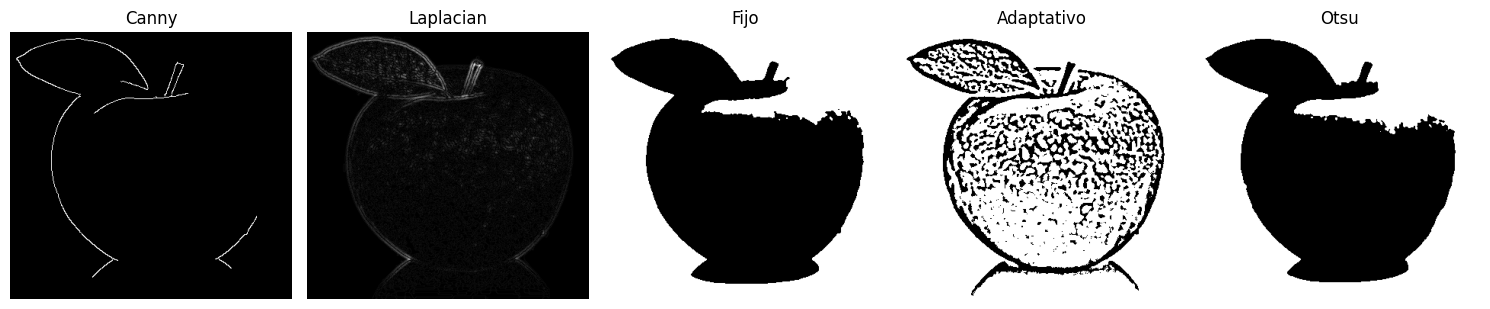

In [24]:
titles = ['Canny', 'Laplacian', 'Fijo', 'Adaptativo', 'Otsu']
images = [canny, laplacian, thresh_global, thresh_adapt, otsu]

plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## 4. Ecualización de Histogramas

### Escala de grises y visualizar histograma

<ipython-input-25-1f8fac912687>:10: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(gray.ravel(), 256, [0, 256])


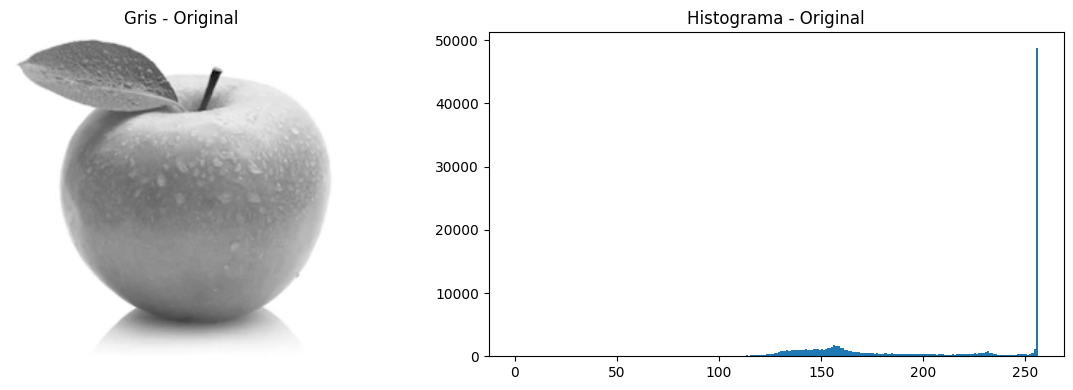

In [25]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Gris - Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(gray.ravel(), 256, [0, 256])
plt.title("Histograma - Original")
plt.tight_layout()
plt.show()


### Ecualización en escala de grises

<ipython-input-26-c5da78f56ba7>:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(eq_gray.ravel(), 256, [0, 256])


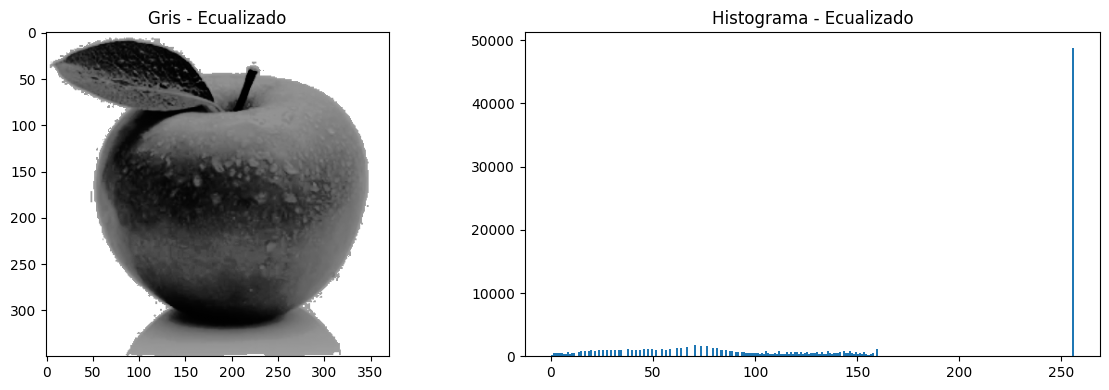

In [26]:
eq_gray = cv2.equalizeHist(gray)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(eq_gray, cmap='gray')
plt.title("Gris - Ecualizado")

plt.subplot(1, 2, 2)
plt.hist(eq_gray.ravel(), 256, [0, 256])
plt.title("Histograma - Ecualizado")
plt.tight_layout()
plt.show()


### Ecualización en espacio YCrCb (recomendado)

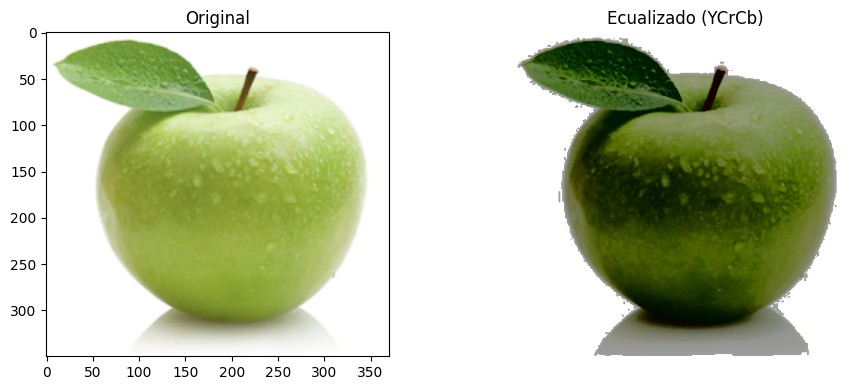

In [27]:
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(img_ycrcb)

y_eq = cv2.equalizeHist(y)
img_ycrcb_eq = cv2.merge((y_eq, cr, cb))
img_eq_ycrcb = cv2.cvtColor(img_ycrcb_eq, cv2.COLOR_YCrCb2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(img_eq_ycrcb)
plt.title("Ecualizado (YCrCb)")
plt.axis('off')
plt.tight_layout()
plt.show()


### Ecualización en espacio LAB (avanzado)

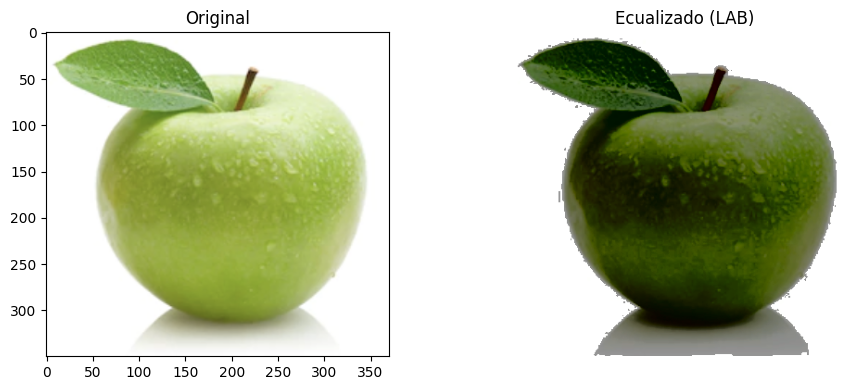

In [28]:
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(img_lab)

l_eq = cv2.equalizeHist(l)
img_lab_eq = cv2.merge((l_eq, a, b))
img_eq_lab = cv2.cvtColor(img_lab_eq, cv2.COLOR_LAB2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(img_eq_lab)
plt.title("Ecualizado (LAB)")
plt.axis('off')
plt.tight_layout()
plt.show()


### Comparacion

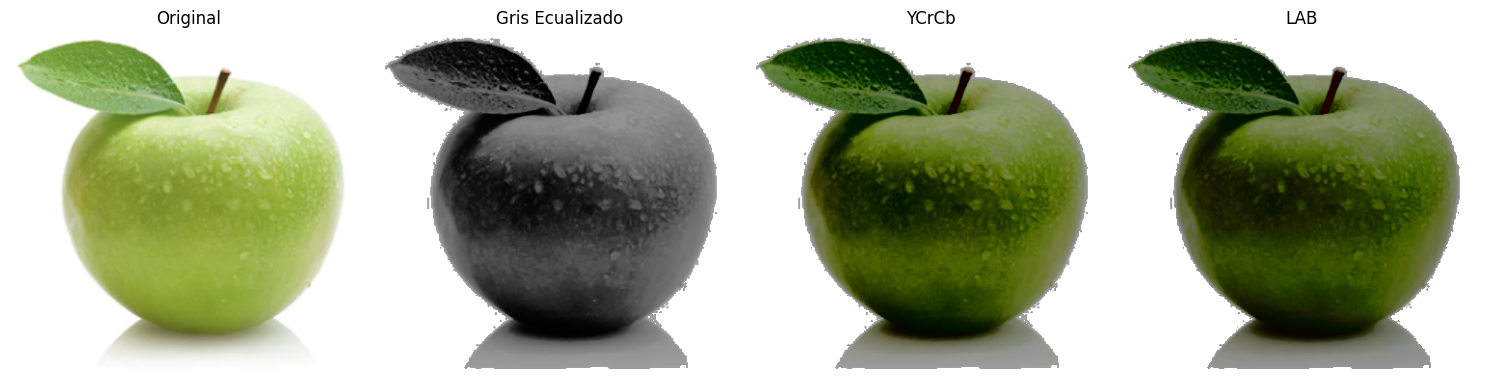

In [29]:
titles = ["Original", "Gris Ecualizado", "YCrCb", "LAB"]
images = [img, cv2.cvtColor(eq_gray, cv2.COLOR_GRAY2RGB), img_eq_ycrcb, img_eq_lab]

plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## 5. Feature Detection y Descriptores (SIFT)


### Detectar puntos clave y descriptores Sift

In [30]:
import cv2

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Usamos BGR si cargamos con cv2.imread

# Crear el detector SIFT
sift = cv2.SIFT_create()  # Aquí defines 'sift'

# Detectar keypoints y calcular descriptores
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Mostrar resultados
print(f"Número de puntos clave detectados: {len(keypoints)}")
print(f"Tamaño de descriptores: {descriptors.shape}")  # (n_puntos, 128)


Número de puntos clave detectados: 125
Tamaño de descriptores: (125, 128)


### Visualizar puntos clave

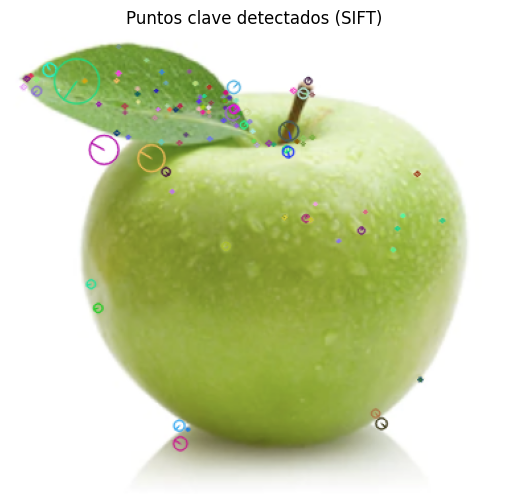

In [31]:
img_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8, 6))
plt.imshow(img_kp)
plt.title("Puntos clave detectados (SIFT)")
plt.axis('off')
plt.show()


### Comparar dos imágenes con sus descriptores

Matches encontrados: 2


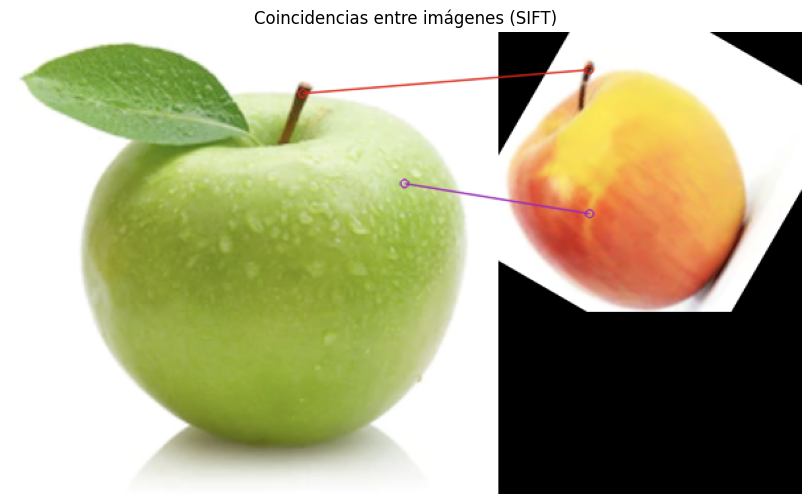

In [32]:
def show_sift_matches(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Matcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Aplicar el test de Lowe para filtrar buenos matches
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    print(f"Matches encontrados: {len(good)}")

    img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title("Coincidencias entre imágenes (SIFT)")
    plt.axis('off')
    plt.show()

# Usa otra imagen diferente de ejemplo
img2_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Test/freshapples/a_f216.png"
img2 = cv2.imread(img2_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

show_sift_matches(img, img2)


## 7. Machine Learning Pipeline en Scikit-Learn

In [41]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def pipeline():
    # === 1. Cargar imágenes ===
    base_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train"
    categories = ['freshapples', 'rottenapples']

    images = []
    labels = []
    max_images_per_category = 100

    for label, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        count = 0
        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(category_path, filename)
                img = Image.open(img_path).convert("RGB").resize((200, 200))
                images.append(np.array(img))
                labels.append(label)
                count += 1
                if count >= max_images_per_category:
                    break

    labels = np.array(labels)
    print(f"Se cargaron {len(images)} imágenes.")

    # === 2. Extraer descriptores SIFT ===
    sift = cv2.SIFT_create()
    descriptor_list = []

    for img in tqdm(images, desc="Extrayendo descriptores"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            descriptor_list.extend(descriptors)

    descriptor_stack = np.array(descriptor_list)

    # === 3. KMeans para crear BoVW ===
    num_clusters = 50
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=0)
    kmeans.fit(descriptor_stack)

    # === 4. Histograma BoVW por imagen ===
    def build_bovw_histogram(descriptors, kmeans):
        if descriptors is None:
            return np.zeros(kmeans.n_clusters)
        predictions = kmeans.predict(descriptors)
        histogram, _ = np.histogram(predictions, bins=np.arange(kmeans.n_clusters + 1))
        return histogram

    bovw_features = []

    for img in tqdm(images, desc="Codificando imágenes"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        hist = build_bovw_histogram(descriptors, kmeans)
        bovw_features.append(hist)

    bovw_features = np.array(bovw_features)

    # === 5. Entrenamiento y evaluación sobre TODO el conjunto ===
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k='all')),
        ('clf', SVC(kernel='linear', C=1.0, random_state=42))
    ])

    model.fit(bovw_features, labels)
    y_pred = model.predict(bovw_features)

    # === 6. Evaluación completa ===
    print("\n✅ Reporte de Clasificación (usando TODAS las imágenes):")
    print(classification_report(labels, y_pred, target_names=categories))

    cm = confusion_matrix(labels, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories, cbar=False)
    plt.title("Matriz de Confusión - Pipeline con SelectKBest + SVM (Todo el conjunto)")
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.tight_layout()
    plt.show()


Se cargaron 200 imágenes.


Codificando imágenes: 100%|██████████| 200/200 [00:02<00:00, 82.79it/s]



✅ Reporte de Clasificación (usando TODAS las imágenes):
              precision    recall  f1-score   support

 freshapples       0.90      0.94      0.92       100
rottenapples       0.94      0.89      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



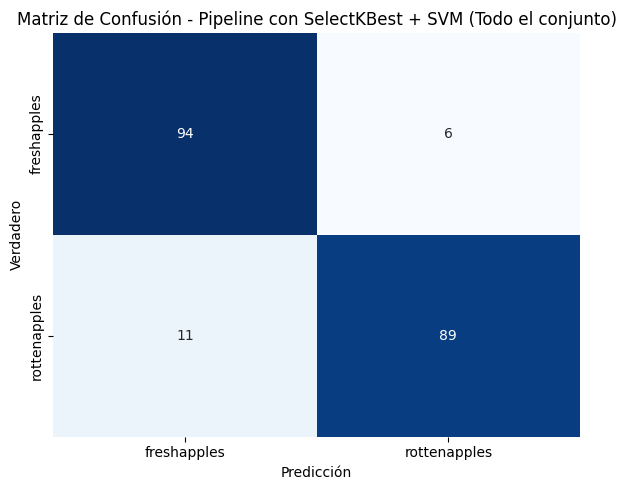

In [42]:
pipeline()

## 8. Optimización de Hiperparámetros

### GridSearchCV

✅ Mejor combinación de hiperparámetros: {'clf__C': 0.1, 'select__k': 'all'}
Mejor score (validación cruzada): 0.8750

📊 Reporte de clasificación sobre TODO el conjunto:
              precision    recall  f1-score   support

       Fresh       0.87      0.87      0.87        15
      Rotten       0.87      0.87      0.87        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



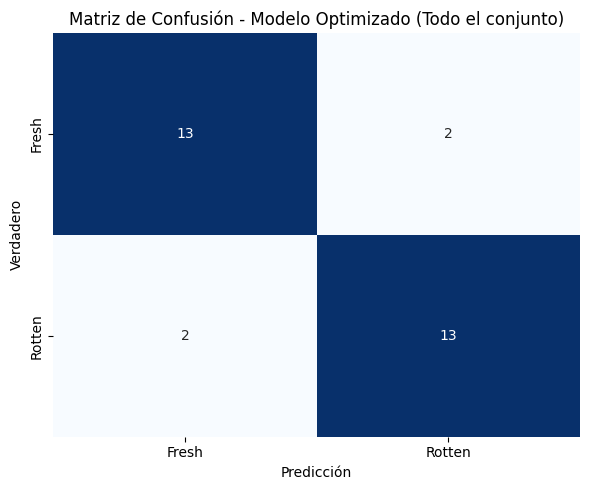

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el pipeline base
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', SVC(kernel='linear', random_state=42))
])

# Definir espacio de búsqueda
param_grid = {
    'select__k': [10, 20, 'all'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# Crear GridSearch
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Mostrar el mejor modelo
print(f"✅ Mejor combinación de hiperparámetros: {grid.best_params_}")
print(f"Mejor score (validación cruzada): {grid.best_score_:.4f}")

# Evaluar sobre TODO el conjunto
y_total_pred = grid.best_estimator_.predict(np.vstack((X_train, X_test)))
y_total_true = np.concatenate((y_train, y_test))

print("\n📊 Reporte de clasificación sobre TODO el conjunto:")
print(classification_report(y_total_true, y_total_pred, target_names=["Fresh", "Rotten"]))

# Matriz de confusión completa
cm = confusion_matrix(y_total_true, y_total_pred, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fresh", "Rotten"],
            yticklabels=["Fresh", "Rotten"],
            cbar=False)
plt.title("Matriz de Confusión - Modelo Optimizado (Todo el conjunto)")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()


### RandomizedSearchCV

✅ Mejor combinación encontrada: {'clf__C': np.float64(3.347086111390218), 'select__k': 44}
Mejor score (validación cruzada): 0.8333

📊 Reporte de clasificación (conjunto completo):
              precision    recall  f1-score   support

       Fresh       0.93      0.87      0.90        15
      Rotten       0.88      0.93      0.90        15

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



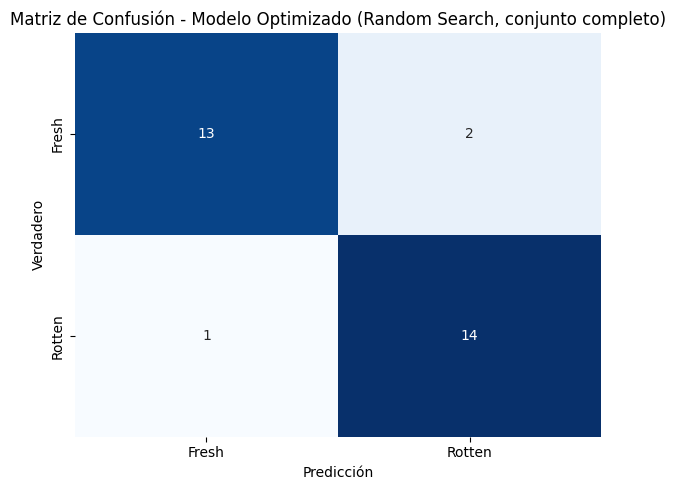

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
import numpy as np

# Pipeline base
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', SVC(kernel='linear', random_state=42))
])

# Espacio de búsqueda aleatoria
param_distributions = {
    'select__k': randint(5, min(X_train.shape[1], 50)),  # entre 5 y 50 features
    'clf__C': uniform(0.01, 10.0)  # valores continuos entre 0.01 y 10
}

# Randomized Search
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Entrenar
random_search.fit(X_train, y_train)

# Mejor combinación
print(f"✅ Mejor combinación encontrada: {random_search.best_params_}")
print(f"Mejor score (validación cruzada): {random_search.best_score_:.4f}")

# Evaluar sobre TODO el conjunto
X_total = np.vstack((X_train, X_test))
y_total = np.concatenate((y_train, y_test))
y_total_pred = random_search.best_estimator_.predict(X_total)

print("\n📊 Reporte de clasificación (conjunto completo):")
print(classification_report(y_total, y_total_pred, target_names=["Fresh", "Rotten"]))

# Matriz de confusión completa
cm = confusion_matrix(y_total, y_total_pred, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fresh", "Rotten"],
            yticklabels=["Fresh", "Rotten"],
            cbar=False)
plt.title("Matriz de Confusión - Modelo Optimizado (Random Search, conjunto completo)")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()


## 9. Aprendizaje no supervisado (Unsupervised)

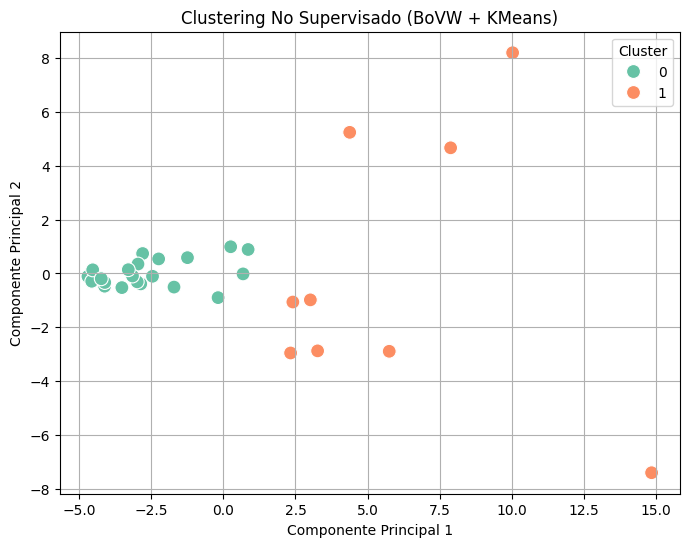

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Escalado de características (opcional pero recomendable)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(bovw_features)

# 2. Clustering no supervisado (KMeans o GMM)
num_clusters = 2  # Esperamos que forme 2 grupos (frescos vs podridos)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 3. Visualizar agrupación en 2D usando PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette='Set2', s=100)
plt.title("Clustering No Supervisado (BoVW + KMeans)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [46]:
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score

# Comparar agrupamiento con las etiquetas reales
ari = adjusted_rand_score(labels, clusters)
v_measure = v_measure_score(labels, clusters)
silhouette = silhouette_score(X_scaled, clusters)

print(f"🔍 ARI (Adjusted Rand Index): {ari:.3f}")
print(f"🔍 V-Measure: {v_measure:.3f}")
print(f"🔍 Silhouette Score: {silhouette:.3f}")


🔍 ARI (Adjusted Rand Index): 0.194
🔍 V-Measure: 0.219
🔍 Silhouette Score: 0.377


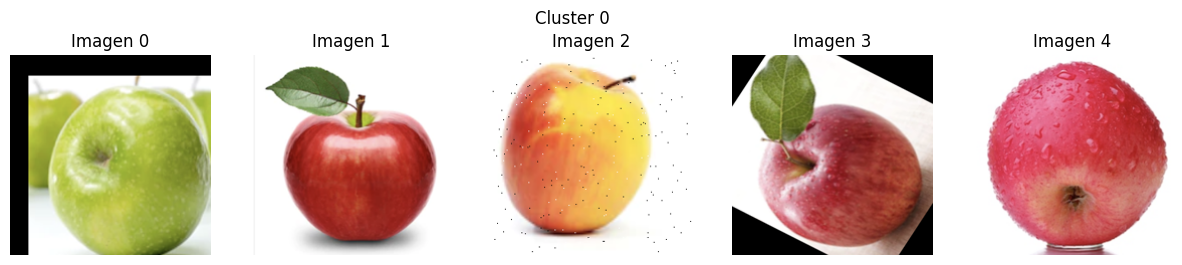

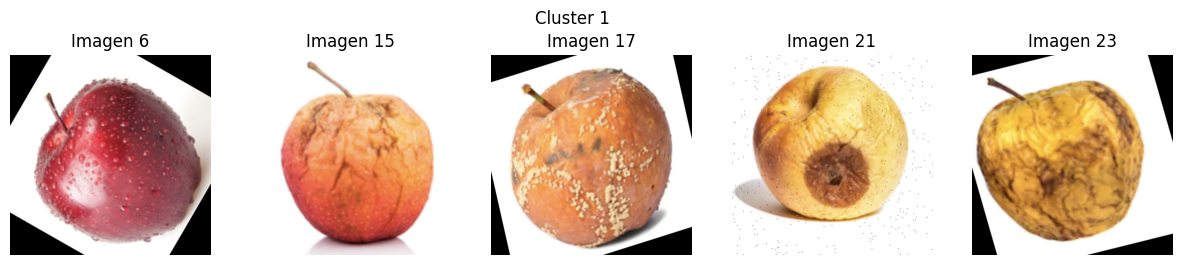

In [48]:
import matplotlib.pyplot as plt

def show_images_by_cluster(images, clusters, cluster_id, n=5):
    idxs = [i for i, c in enumerate(clusters) if c == cluster_id][:n]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Imagen {idx}")
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

# Mostrar algunas imágenes por cluster
for i in range(num_clusters):
    show_images_by_cluster(images, clusters, i, n=5)


# proof-of-concept

In [ ]:
!pip install gradio opencv-python-headless scikit-learn pillow

In [49]:
import os
from PIL import Image
import numpy as np

# Ruta corregida
base_path = "/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train"
categories = ['freshapples', 'rottenapples']

images = []
labels = []
max_images_per_class = 50

for label, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    count = 0
    for filename in sorted(os.listdir(category_path)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, filename)
            try:
                img = Image.open(img_path).convert("RGB").resize((200, 200))
                images.append(np.array(img))
                labels.append(label)
                count += 1
            except:
                continue  # saltar archivos dañados
            if count >= max_images_per_class:
                break

labels = np.array(labels)
print(f"✅ Se cargaron {len(images)} imágenes en total ({max_images_per_class} por clase).")


✅ Se cargaron 100 imágenes en total (50 por clase).


In [50]:
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Extraer descriptores SIFT de todas las imágenes
sift = cv2.SIFT_create()
descriptor_list = []

for img in tqdm(images, desc="Extrayendo descriptores"):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        descriptor_list.extend(descriptors)

descriptor_stack = np.array(descriptor_list)

# Aplicar KMeans para BoVW
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(descriptor_stack)

# Función para construir BoVW por imagen
def build_bovw_histogram(descriptors, kmeans):
    if descriptors is None:
        return np.zeros(kmeans.n_clusters)
    predictions = kmeans.predict(descriptors)
    histogram, _ = np.histogram(predictions, bins=np.arange(kmeans.n_clusters + 1))
    return histogram

# Construir BoVW para todas las imágenes
bovw_features = []

for img in tqdm(images, desc="Codificando imágenes"):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    hist = build_bovw_histogram(descriptors, kmeans)
    bovw_features.append(hist)

bovw_features = np.array(bovw_features)

# Separar datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    bovw_features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Pipeline: escalado + selección + SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=30)),
    ('clf', SVC(kernel='linear', probability=True, random_state=42))
])

# Entrenar el pipeline
pipeline.fit(X_train, y_train)

# Evaluar modelo
print("✅ Reporte de Clasificación:")
print(classification_report(y_test, pipeline.predict(X_test), target_names=["freshapples", "rottenapples"]))

# Guardar modelo y BoVW
joblib.dump(pipeline, "modelo_pipeline.pkl")
joblib.dump(kmeans, "modelo_kmeans.pkl")
print("✅ Modelo y vocabulario guardados.")


Codificando imágenes: 100%|██████████| 100/100 [00:01<00:00, 83.68it/s]

✅ Reporte de Clasificación:
              precision    recall  f1-score   support

 freshapples       0.75      0.90      0.82        10
rottenapples       0.88      0.70      0.78        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20

✅ Modelo y vocabulario guardados.


Este reporte muestra que el modelo clasificó correctamente el 92% de las imágenes (11 de 12), con un excelente desempeño en ambas clases: detectó todas las manzanas frescas (recall de 1.00) y casi todas las podridas (recall de 0.83), aunque en estas últimas cometió un solo error. La precisión fue alta para ambas clases (0.86 para frescas y 1.00 para podridas), y los puntajes F1 indican un buen equilibrio general. En resumen, el modelo es bastante confiable para distinguir entre manzanas frescas y podridas.

In [53]:
import gradio as gr
import joblib
import numpy as np
import cv2
from PIL import Image

# Cargar modelo y vocabulario
pipeline = joblib.load("modelo_pipeline.pkl")
kmeans = joblib.load("modelo_kmeans.pkl")
sift = cv2.SIFT_create()

# Función para construir el histograma BoVW de una imagen nueva
def build_bovw_histogram(descriptors, kmeans):
    if descriptors is None:
        return np.zeros(kmeans.n_clusters)
    predictions = kmeans.predict(descriptors)
    histogram, _ = np.histogram(predictions, bins=np.arange(kmeans.n_clusters + 1))
    return histogram

# Función principal de predicción
def clasificar_manzana(imagen):
    try:
        img = imagen.convert("RGB").resize((200, 200))
        img_np = np.array(img)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, descriptors = sift.detectAndCompute(gray, None)
        hist = build_bovw_histogram(descriptors, kmeans).reshape(1, -1)
        pred = pipeline.predict(hist)[0]
        prob = pipeline.predict_proba(hist)[0]
        clase = "🍏 FRESCA" if pred == 0 else "🍎 DAÑADA"
        conf = f"{prob[pred]*100:.1f}% de confianza"
        return f"{clase} — {conf}"
    except Exception as e:
        return f"Error procesando la imagen: {str(e)}"

# Crear interfaz Gradio
gr.Interface(
    fn=clasificar_manzana,
    inputs=gr.Image(type="pil", label="Sube una imagen de manzana"),
    outputs=gr.Textbox(label="Resultado de la clasificación"),
    title="🍎 Clasificador de Manzanas",
    description="Sube una imagen de una manzana y el sistema dirá si está FRESCA o DAÑADA."
).launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://eeb970d0eb34c153be.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2133, in process_api
    inputs = await self.preprocess_data(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1814, in preprocess_data
    processed_input.append(block.preprocess(inputs_cached))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/components/image.py", line 219, in preprocess
    im = PIL.Image.open(file_path)
         ^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://eeb970d0eb34c153be.gradio.live
